In [2]:
# import Pkg; Pkg.add(url="https://github.com/Red-Portal/SteinDiscrepancy.jl.git")
using Random, Distributions, RData

In [3]:
# import the kernel stein discrepancy function and kernel to use
using SteinDiscrepancy: SteinInverseMultiquadricKernel, ksd
# create the kernel instance
kernel = SteinInverseMultiquadricKernel()

┌ Info: Precompiling SteinDiscrepancy [47571ba0-6b7d-4e5f-b5d0-9456c75a042d]
└ @ Base loading.jl:1342
┌ Warning: Package SteinDiscrepancy does not have LinearAlgebra in its dependencies:
│ - If you have SteinDiscrepancy checked out for development and have
│   added LinearAlgebra as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with SteinDiscrepancy
└ Loading LinearAlgebra into SteinDiscrepancy from project dependency, future warnings for SteinDiscrepancy are suppressed.


SteinInverseMultiquadricKernel(0.5, 1.0)

In [4]:
# Prior
t_dist_df = 2;
a0 = 1;
b0 = 1;

# define the grad beta of log density of half-t prior
function grad_beta_log_prior(eta_beta_xi_sigma2::Vector{Float64})
    eta = eta_beta_xi_sigma2[1];
    beta = eta_beta_xi_sigma2[2];
    xi = eta_beta_xi_sigma2[3];
    sigma2 = eta_beta_xi_sigma2[4];
    p = 1; 
    
    grad_eta = -(beta.*beta).*xi./(2*sigma2)+(1 ./ eta)*((t_dist_df - 1)/2)-(1 ./ (1 .+ t_dist_df .* eta))*((t_dist_df + 1)/2);
    grad_beta =  - ((beta.*eta).*xi)./(sigma2);
    
    grad_xi = -1 ./ (1 .+ xi) + ((p-1) ./ 2) ./ xi - sum(beta.*beta.*eta)./(2 .* sigma2);
    grad_sigma2 = -((p+a0)/2 +1)*(1 ./ sigma2) + (b0 .+ sum(beta.*beta.*eta).*xi)./(2*(sigma2.^2));
    output = vcat(grad_eta,grad_beta,grad_xi,grad_sigma2);
    output
end

grad_beta_log_prior (generic function with 1 method)

In [5]:
# Generate samples from the prior
nsamples = 5000
sigma2_samples = rand(Gamma(a0/2, (2/b0)),nsamples).^(-1);
eta_samples = rand(TDist(t_dist_df), nsamples).^(-2);
xi_samples = rand(Cauchy(0, 1), nsamples).^(-2);
beta_samples = rand(Normal(0, 1), nsamples).*(sigma2_samples./(eta_samples.*xi_samples)).^(0.5);

samples = hcat(eta_samples, beta_samples,xi_samples,sigma2_samples);

In [6]:
grads = zeros(size(samples))
for i in [1:1:nsamples;]
    grads[i,:] = grad_beta_log_prior(samples[i,:])
end
# gradlogp(samples[10,:])

In [14]:
[mean(grads, dims=1), var(grads, dims=1)/(nsamples)]

2-element Vector{Matrix{Float64}}:
 [-0.29406667862355623 -3.5820168133297505 -102876.92145123208 -0.0418562582934613]
 [0.3319289076469292 6.691400264670528 1.0241332039010279e10 0.002125262088551286]

In [9]:
interval = 10
npoints = trunc(Int,nsamples/interval)
kernel_stein_discrepancy = zeros(((npoints-1),1))
# compute the KSD2
for i in [2:1:npoints;]
    result = ksd(points=samples[1:(i*interval),:], gradlogdensity=grad_beta_log_prior, kernel=kernel)
    # get the final ksd
    kernel_stein_discrepancy[(i-1)] = sqrt(result.discrepancy2)
    print(i)
end

2345678910111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989910010110210310410510610710810911011111211311411511611711811912012112212312412512612712812913013113213313413513613713813914014114214314414514614714814915015115215315415515615715815916016116216316416516616716816917017117217317417517617717817918018118218318418518618718818919019119219319419519619719819920020120220320420520620720820921021121221321421521621721821922022122222322422522622722822923023123223323423523623723823924024124224324424524624724824925025125225325425525625725825926026126226326426526626726826927027127227327427527627727827928028128228328428528628728828929029129229329429529629729829930030130230330430530630730830931031131231331431531631731831932032132232332432532632732832933033133233333433533633733833934034134234334434534634734834935035135235335435535635735835936036136236336436536636736836937

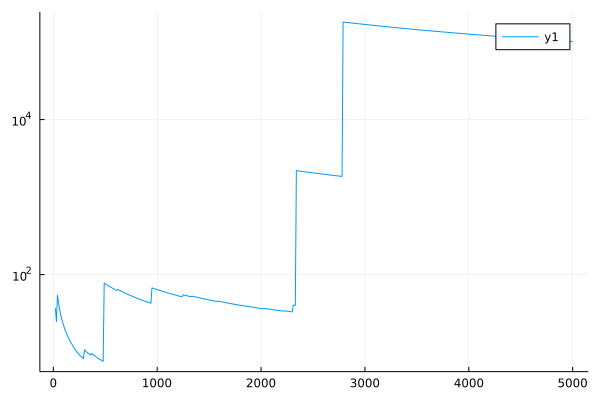

In [12]:
using Statistics, Plots
plot([2:1:npoints;]*interval,kernel_stein_discrepancy, yaxis=:log)

In [13]:
using CSV, Tables
CSV.write("ksd_half_t_prior.csv", Tables.table(hcat([2:1:npoints;]*interval, kernel_stein_discrepancy)))

"ksd_half_t_prior.csv"